In [1]:
dataset_name = "ambient_temperature_system_failure"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


#  Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2013-12-22 20:00:00",
                      "2014-04-13 09:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2013-07-04 00:00:00
End date:  2014-05-28 15:00:00
Missing time stamps: 
 DatetimeIndex(['2013-07-28 02:00:00', '2013-07-28 05:00:00',
               '2013-07-28 06:00:00', '2013-07-28 07:00:00',
               '2013-07-28 08:00:00', '2013-07-28 09:00:00',
               '2013-07-28 10:00:00', '2013-07-28 11:00:00',
               '2013-07-28 12:00:00', '2013-07-28 13:00:00',
               ...
               '2014-04-10 05:00:00', '2014-04-10 06:00:00',
               '2014-04-10 07:00:00', '2014-04-10 08:00:00',
               '2014-04-10 09:00:00', '2014-04-10 10:00:00',
               '2014-04-10 11:00:00', '2014-04-10 12:00:00',
               '2014-04-10 13:00:00', '2014-04-10 14:00:00'],
              dtype='datetime64[ns]', length=621, freq=None)
Length:  7888
Time step size:  1H
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [4124, 6801]


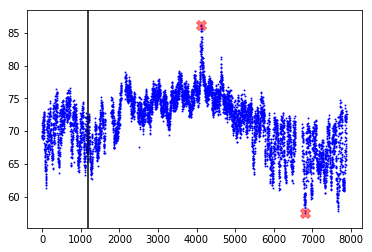

In [4]:
ad.plot_outliers([],true_outlier_indices)

# SARIMA


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : 2804.334
 Regression with ARIMA(0,1,0) errors : 3186.599
 Regression with ARIMA(1,1,0) errors : 3016.944
 Regression with ARIMA(0,1,1) errors : 2836.492
 ARIMA(0,1,0)                    : 3184.49
 Regression with ARIMA(1,1,2) errors : 2813.944
 Regression with ARIMA(2,1,1) errors : 2822.523
 Regression with ARIMA(3,1,2) errors : 2803.575
 Regression with ARIMA(3,1,1) errors : 2802.35
 Regression with ARIMA(3,1,0) errors : 2997.03
 Regression with ARIMA(4,1,1) errors : 2797.096
 Regression with ARIMA(4,1,0) errors : 2997.263
 Regression with ARIMA(5,1,1) errors : 2793.916
 Regression with ARIMA(5,1,0) errors : 2994.059
 Regression with ARIMA(5,1,2) errors : 2795.868
 Regression with ARIMA(4,1,2) errors : 2799.082
 ARIMA(5,1,1)                    : 2786.239
 ARIMA(4,1,1)                    : 2788.799
 ARIMA(5,1,0)                    : 2991.914
 ARIMA(5,1,2)                    : 2787.578
 A

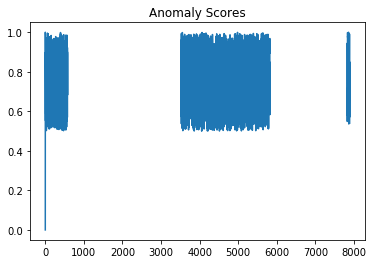

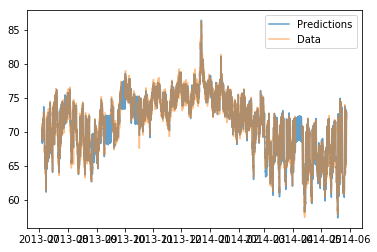

Time:  144.55367755889893


['anomaly_scores/SARIMA_auto/ambient_temperature_system_failure_no_fill']

In [5]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name + "_no_fill"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [6]:
# optimization step

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.1796262225574035


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.0011385072331476


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.9190442659853884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9168062153871492


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.9240020979168637


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.33163346117102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1704433622200354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.056701867109787


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.0704295174199454


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.058967549481749


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.145150345846552


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.0063797788426263


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.93104612603584


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9194361770879893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.9209418135802747


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.3657569553102444


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.205478101480802


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.072001182261269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.084846532586507


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.0634152222810695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.2831483962506067


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  2.986200877680565


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.9119833277567966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9214832405219786


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.924615639572936


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.2866272391276268


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1664704464957905


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.0737194896846676


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.0764980072558346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.0643967848557554


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.2291910535165216


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.028698225814486


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.9150730952433417


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.913033113665645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.930986561106953


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.331459549731999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1375257397899294


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.0795407963066728


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.075708116859756


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.071866218708652


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.307933310057839


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  2.9835765418472873


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.922573150175239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9219862138254107


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.9257392977624668


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.4317180285665385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1582524053813272


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.0705522763564517


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.071105445813352


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.0669310078142566


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.1796262225574035


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.0011385072331476


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.9190442659853884


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9168062153871492


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.9240020979168637


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.33163346117102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1704433622200354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.056701867109787


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.0704295174199454


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.058967549481749


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.145150345846552


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.0063797788426263


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.93104612603584


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9194361770879893


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.9209418135802747


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.3657569553102444


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.205478101480802


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.072001182261269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.084846532586507


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.0634152222810695


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.2831483962506067


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  2.986200877680565


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.9119833277567966


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9214832405219786


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.924615639572936


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.2866272391276268


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1664704464957905


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.0737194896846676


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.0764980072558346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.0643967848557554


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.2291910535165216


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  3.028698225814486


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.9150730952433417


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.913033113665645


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.930986561106953


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.331459549731999


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1375257397899294


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.0795407963066728


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.075708116859756


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.071866218708652


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  3.307933310057839


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  2.9835765418472873


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  2.922573150175239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  2.9219862138254107


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  2.9257392977624668


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  3.4317180285665385


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  3.1582524053813272


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  3.0705522763564517


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  3.071105445813352
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  3.0669310078142566

best params:  Step Size 100 Seasonality Prior Scale 10 Seasonality Mode additive Changepoint Prior Scale0.1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


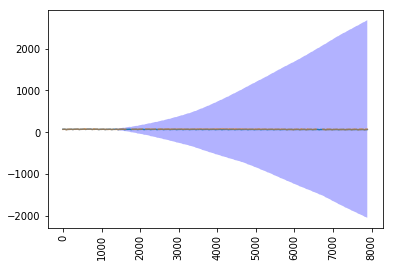

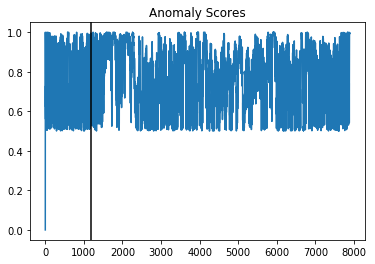

Time:  29.358802318572998


['anomaly_scores/Prophet/ambient_temperature_system_failure_no_fill']

In [7]:
save_path = "anomaly_scores/Prophet/" + dataset_name + "_no_fill"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=10,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.1,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

#  STL Resid

In [8]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.09771928940435
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.2113607453712
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.03452366678584
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.09771928940435
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.00240783029673
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.05762200362125

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  268.0919188057411
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  267.70789257901384
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  267.7605268475954
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  267.69291714246367
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  267.7240630155492
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  418.9626831844469
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
1183


R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  319.9013753174341
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  319.8898303916967
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  319.889759396758
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  193.22504336613628
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  193.39844331455214
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  193.17862320485565
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  2
outer:  1
1183
R 

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  233.05762200362125
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  231.08660873307628
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  231.27399490243573
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  231.05931305972555
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  231.08660873307628
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  231.05605468321227
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  3
outer:  1
118

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  418.8919656936939
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  418.76118695655606
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  418.9626831844469
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  418.6322878730106
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  418.8386258206448
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  402.339387142371
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  1
inner:  1
outer:  1
118

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  99.7414024103758
swindow:  5
sdegree:  0
twindow:  7
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  99.56975015071755
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  185.58519555133248
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  184.24337280001873
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  187.1986457896769
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  185.58519555133248
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fil

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.07331305289771121
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.09465465845437662
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.06628618292847986
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.08141724258236675
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  151.08543678240088
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  150.96573968773785
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. 

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.55825093971157
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.87932751243258
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.74542856065733
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.55825093971157
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.75929375422996
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.71393284379195
swindow:  5
sdegree:  2
twindow:  5
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing.

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  8.999772509583183
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  8.95305432727419
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  6.983315778903921
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  7.800298002247045
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  7.009161990253778
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  6.983315778903921
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. 

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  213.32525068982198
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  212.47972024117286
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  213.48550216450744
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  213.11735692472803
swindow:  7
sdegree:  0
twindow:  7
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  131.33554121818136
swindow:  7
sdegree:  0
twindow:  7
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  130.99560874370525
swindow:  7
sdegree:  0
twindow:  7
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  150.5764310573442
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  150.36796145478166
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  151.22301396029079
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  150.5764310573442
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  151.28692707844095
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  151.099433724794
swindow:  7
sdegree:  1
twindow:  5
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fil

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  265.001188450336
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  264.62409872968124
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  253.01396232923994
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  252.19381544959197
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  254.08519339076372
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  253.01396232923994
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. 

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  148.72944557507412
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  148.81737515523503
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  148.85258787769294
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  148.73483071067463
swindow:  7
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.27030336962383
swindow:  7
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  145.44489367374376
swindow:  7
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  249.78042876111834
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  248.0209558792514
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  249.9228575797414
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  249.78042876111834
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  249.8109551621111
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  249.96339005697646
swindow:  9
sdegree:  0
twindow:  7
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fi

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  238.43562486670098
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  238.35649528804817
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  174.99519657614573
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  174.39644808391876
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  175.48476373860004
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  174.99519657614573
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. wil

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  199.0521322835648
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  198.8483405077322
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  199.0042490364081
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  199.05361262849024
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  306.0330443239868
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  305.2273524119026
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will f

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  107.87321705104858
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  109.3608547681647
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  108.13749498377643
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  107.87321705104858
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  108.13700098304545
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  108.1343798459472
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will f

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  191.62340533200828
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  191.57827671756647
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.3967540053439551
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.3478711437154258
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.39740727912052415
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  0.3967540053439551
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  0
1183
R stlplus completed: 1183  missin

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  326.8468567471168
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  327.76943796566974
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  327.31909983976936
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  327.8861096545238
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  327.64391764313115
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  255.5485979343128
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
1183
R stlplus completed: 1183  miss

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  293.9882344607687
swindow:  11
sdegree:  1
twindow:  9
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  293.93656110791954
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  288.2584092996917
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  289.27959003733724
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  288.71026923271256
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  288.2584092996917
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. w

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  213.16443992438997
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  212.97215204124444
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  2
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  212.5288021495298
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  212.8583586739717
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  212.8794612800536
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  209.09758159144786
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
1183
R stlplus completed: 1183  missing. w

R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  203.53707075527183
swindow:  11
sdegree:  2
twindow:  11
tdegree:  2
inner:  3
outer:  1
1183
R stlplus completed: 1183  missing. will fill. True
STL Resid Sum:  203.62465955248916

best params:  swindow 7 sdegree 2 twindow 5 tdegree 2 inner 3 outer 0


In [9]:
save_path = "anomaly_scores/stl/" + dataset_name + "_no_fill"
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=7, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

7888
R stlplus completed: 7888  missing. will fill. True
Time:  2.2766802310943604


['anomaly_scores/stl/ambient_temperature_system_failure_no_fill']

# GLM

In [10]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


 43%|████▎     | 3158/7267 [00:00<00:00, 31570.17it/s]

eta:  0.5
lambda:  0.99
MSE:  inf
Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


 42%|████▏     | 3040/7267 [00:00<00:00, 30387.42it/s]

eta:  0.5
lambda:  0.999
MSE:  14.66959036368247
Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


 40%|███▉      | 2884/7267 [00:00<00:00, 28834.80it/s]

eta:  0.5
lambda:  0.9999
MSE:  19.282861267422188
Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


 41%|████      | 2949/7267 [00:00<00:00, 29479.34it/s]

eta:  1
lambda:  0.99
MSE:  4.322268879766412e+34
Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


 40%|████      | 2930/7267 [00:00<00:00, 29286.97it/s]

eta:  1
lambda:  0.999
MSE:  10.110698588358789
Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


100%|██████████| 7267/7267 [00:00<00:00, 28500.50it/s]


eta:  1
lambda:  0.9999
MSE:  17.29689694313435

best params:  eta 1 lambda 0.999


 41%|████      | 2949/7267 [00:00<00:00, 29484.62it/s]

Initial Mean 70.06345351871512
Initial StdDev 2.9718413391726273


100%|██████████| 7267/7267 [00:00<00:00, 28992.90it/s]


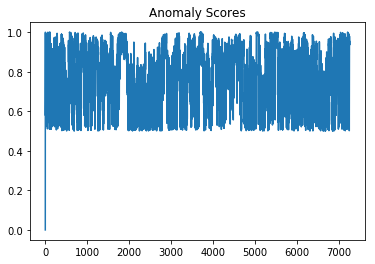

Time:  1.2282865047454834


['anomaly_scores/GLM/ambient_temperature_system_failure_no_fill']

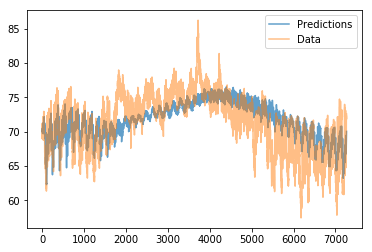

In [11]:
save_path = "anomaly_scores/GLM/" + dataset_name + "_no_fill"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)
